<a href="https://colab.research.google.com/github/Nikhil-Khetani/Tesla-Stock-Price-Predictor/blob/main/pytorch_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
style.use('ggplot')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

start = datetime(2011, 1, 1)
end = datetime(2021, 1, 1)

df = web.DataReader('TSLA', 'yahoo', start, end).reset_index(level=0)
'''
df.to_csv('tsla.csv')

df = pd.read_csv('tsla.csv', index_col=0).reset_index()
'''
df.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-03,5.400,5.180,5.368,5.324,6415000.0,5.324
1,2011-01-04,5.390,5.204,5.332,5.334,5937000.0,5.334
2,2011-01-05,5.380,5.238,5.296,5.366,7233500.0,5.366
3,2011-01-06,5.600,5.362,5.366,5.576,10306000.0,5.576
4,2011-01-07,5.716,5.580,5.600,5.648,11239500.0,5.648


In [2]:
df = pd.DataFrame(df[['Date','Adj Close']])
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Adj Close
0,2011-01-03,5.324
1,2011-01-04,5.334
2,2011-01-05,5.366
3,2011-01-06,5.576
4,2011-01-07,5.648


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2517 non-null   datetime64[ns]
 1   Adj Close  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df['2015'].head()

,Adj Close
Date,
2015-01-02,43.862000
2015-01-05,42.018002
2015-01-06,42.256001
2015-01-07,42.189999
2015-01-08,42.124001


In [6]:
date_range = df.index.max()-df.index.min()
print(date_range)

3650 days 00:00:00


In [7]:
new_index = pd.date_range(df.index.min(),df.index.max())
df = df.reindex(new_index)

In [8]:
df['Adj Close'].value_counts(dropna=False)

NaN          1134
5.484000        4
42.018002       3
5.424000        3
6.492000        3
             ... 
56.366001       1
48.292000       1
42.888000       1
39.209999       1
49.548000       1
Name: Adj Close, Length: 2354, dtype: int64

In [9]:
df['Adj Close'].interpolate(method='linear', inplace=True)

In [10]:
df['Adj Close'].value_counts(dropna=False)


5.484000     4
5.634000     3
6.492000     3
5.320000     3
42.018002    3
            ..
45.557999    1
4.748500     1
34.335499    1
25.804000    1
6.750000     1
Name: Adj Close, Length: 3471, dtype: int64

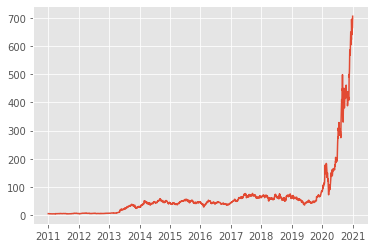

In [11]:
plt.plot(df)

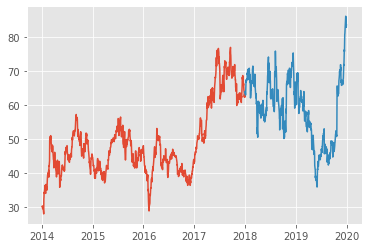

In [12]:
train_data = df['2014':'2017']
test_data = df['2018':'2019']

plt.plot(train_data)
plt.plot(test_data)

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_scaled = scaler.fit_transform(train_data)

In [14]:
train_data_scaled

array([[-0.91105591],
       [-0.91239923],
       [-0.91679555],
       ...,
       [ 0.4003908 ],
       [ 0.41907519],
       [ 0.43775957]])

In [15]:
train_data_scaled = torch.FloatTensor(train_data_scaled).view(-1).to(device)

In [16]:
train_data_scaled

tensor([-0.9111, -0.9124, -0.9168,  ...,  0.4004,  0.4191,  0.4378],
       device='cuda:0')

In [17]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [18]:
train_window = 30
train_inout_seq = create_inout_sequences(train_data_scaled, train_window)

In [19]:
train_inout_seq[:5]

[(tensor([-0.9111, -0.9124, -0.9168, -0.9237, -0.9307, -0.9376, -0.9184, -0.9028,
          -0.9333, -0.9481, -0.9654, -0.9827, -1.0000, -0.8215, -0.7982, -0.7425,
          -0.7503, -0.7367, -0.7232, -0.7096, -0.6960, -0.6807, -0.6568, -0.7129,
          -0.7265, -0.7400, -0.7535, -0.6822, -0.7078, -0.6459], device='cuda:0'),
  tensor([-0.6575], device='cuda:0')),
 (tensor([-0.9124, -0.9168, -0.9237, -0.9307, -0.9376, -0.9184, -0.9028, -0.9333,
          -0.9481, -0.9654, -0.9827, -1.0000, -0.8215, -0.7982, -0.7425, -0.7503,
          -0.7367, -0.7232, -0.7096, -0.6960, -0.6807, -0.6568, -0.7129, -0.7265,
          -0.7400, -0.7535, -0.6822, -0.7078, -0.6459, -0.6575], device='cuda:0'),
  tensor([-0.6692], device='cuda:0')),
 (tensor([-0.9168, -0.9237, -0.9307, -0.9376, -0.9184, -0.9028, -0.9333, -0.9481,
          -0.9654, -0.9827, -1.0000, -0.8215, -0.7982, -0.7425, -0.7503, -0.7367,
          -0.7232, -0.7096, -0.6960, -0.6807, -0.6568, -0.7129, -0.7265, -0.7400,
          -0.7535,

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [21]:
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [54]:
epochs = 150
model.train()
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()


    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00028149
epoch:   1 loss: 0.00026116
epoch:   2 loss: 0.00026323
epoch:   3 loss: 0.00038162
epoch:   4 loss: 0.00105803
epoch:   5 loss: 0.00256502
epoch:   6 loss: 0.00012053
epoch:   7 loss: 0.00008631
epoch:   8 loss: 0.00013354
epoch:   9 loss: 0.00005923
epoch:  10 loss: 0.00011114
epoch:  11 loss: 0.00000111
epoch:  12 loss: 0.00065212
epoch:  13 loss: 0.00016569
epoch:  14 loss: 0.00023289
epoch:  15 loss: 0.00030661
epoch:  16 loss: 0.00055735
epoch:  17 loss: 0.00073313
epoch:  18 loss: 0.00035949
epoch:  19 loss: 0.00026764
epoch:  20 loss: 0.00048124
epoch:  21 loss: 0.00022257
epoch:  22 loss: 0.00044220
epoch:  23 loss: 0.00248502
epoch:  24 loss: 0.00013968
epoch:  25 loss: 0.00041970
epoch:  26 loss: 0.00044915
epoch:  27 loss: 0.00043219
epoch:  28 loss: 0.00046533
epoch:  29 loss: 0.00024282
epoch:  30 loss: 0.00010203
epoch:  31 loss: 0.00124673
epoch:  32 loss: 0.00023896
epoch:  33 loss: 0.00002614
epoch:  34 loss: 0.00002391
epoch:  35 loss: 0.0

In [50]:
fut_pred = 400

test_inputs = torch.Tensor(train_data_scaled[-train_window:].tolist()).to(device)
print(test_inputs)

tensor([0.3575, 0.3539, 0.3503, 0.3381, 0.4159, 0.3995, 0.4312, 0.4686, 0.5060,
        0.5434, 0.6420, 0.6257, 0.6165, 0.6617, 0.6493, 0.6369, 0.6244, 0.5612,
        0.5439, 0.5657, 0.5131, 0.4970, 0.4809, 0.4648, 0.4488, 0.4028, 0.4330,
        0.4004, 0.4191, 0.4378], device='cuda:0')


In [51]:
model.eval()

for i in range(fut_pred):
    seq = test_inputs[-train_window:]
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs = torch.cat((test_inputs, model(seq)), 0)
        # test_inputs.append(model(seq).item())

In [52]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:].cpu() ).reshape(-1, 1))
print(actual_predictions)

[[65.20967 ]
 [67.00727 ]
 [68.604515]
 [69.722855]
 [70.54435 ]
 [71.09363 ]
 [71.467995]
 [71.725   ]
 [71.91009 ]
 [72.05176 ]
 [72.16718 ]
 [72.26569 ]
 [72.35227 ]
 [72.4294  ]
 [72.49819 ]
 [72.55942 ]
 [72.61374 ]
 [72.6618  ]
 [72.704475]
 [72.7425  ]
 [72.77635 ]
 [72.80676 ]
 [72.83427 ]
 [72.85935 ]
 [72.8823  ]
 [72.90347 ]
 [72.92332 ]
 [72.94172 ]
 [72.95894 ]
 [72.974945]
 [72.98971 ]
 [73.00273 ]
 [73.013695]
 [73.022545]
 [73.02948 ]
 [73.03483 ]
 [73.03894 ]
 [73.042145]
 [73.0447  ]
 [73.0468  ]
 [73.04856 ]
 [73.05008 ]
 [73.051414]
 [73.052574]
 [73.05361 ]
 [73.05451 ]
 [73.05531 ]
 [73.056   ]
 [73.05661 ]
 [73.05714 ]
 [73.057594]
 [73.058   ]
 [73.05835 ]
 [73.05865 ]
 [73.05891 ]
 [73.059135]
 [73.05933 ]
 [73.0595  ]
 [73.05965 ]
 [73.05978 ]
 [73.05988 ]
 [73.059975]
 [73.06005 ]
 [73.06011 ]
 [73.06017 ]
 [73.06022 ]
 [73.06026 ]
 [73.06029 ]
 [73.06032 ]
 [73.06034 ]
 [73.060356]
 [73.06037 ]
 [73.06039 ]
 [73.0604  ]
 [73.06042 ]
 [73.060425]
 [73.06043 ]

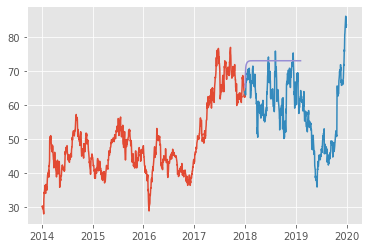

In [53]:
test_dates = pd.date_range(train_data.index[-train_window]+timedelta(days=30),train_data.index[-1]+timedelta(days=fut_pred))
plt.plot(train_data)
plt.plot(test_data)
plt.plot(test_dates, actual_predictions)
